# Import packages

In [2]:
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings(('ignore'))
from ta.momentum import rsi
from ta.volume import volume_weighted_average_price

from scipy.signal import savgol_filter

from kucoin.client import Market
import pandas as pd
import numpy as np
from datetime import datetime
import time
import math
client = Market(url='https://api.kucoin.com')
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [3]:
def polynomialRegression(dataframe, column, order,auto_order=True):
    indexs_2 = np.array([i for i in range(len(dataframe[column].values))])
    indexs_2 = np.reshape(indexs_2, newshape=(1,-1))[0]
    if auto_order==True:
        RMSEs = []
        for i in range(order):
            features = PolynomialFeatures(degree=i+1)
            x_train_transformed = features.fit_transform(indexs_2.reshape(-1, 1))
            
            model = LinearRegression().fit(x_train_transformed, dataframe[column].values)

            train_pred = model.predict(x_train_transformed)
            rmse_poly_4_train = mean_squared_error(dataframe[column].values, train_pred, squared = False)
            RMSEs.append(rmse_poly_4_train)

        features = PolynomialFeatures(degree=RMSEs.index(min(RMSEs))+1)
        
    else:
        features = PolynomialFeatures(order)

    x_train_transformed = features.fit_transform(indexs_2.reshape(-1, 1))
    model = LinearRegression().fit(x_train_transformed, dataframe[column].values) 
    x_test_transformed = features.fit_transform(indexs_2.reshape(-1, 1))

    train_pred = model.predict(x_train_transformed)

    test_pred = model.predict(x_test_transformed)
    
    dataframe[f'Poly_{column}'] = test_pred
    return test_pred

def fourrierFeatureGeneration(df, column, order=30) -> list:
    """Generate a fourrier transformed column in a dataframe with a specified order and column.

    Args:
        df (pd.DataFrame): The dataframe which you want to add a fourrier column
        column (str): The column of the dataframe which you want to compute fft
        order (int, optional): The order of the fourrier transformation. Defaults to 30.

    Returns:
        list: _description_
    """
    close_fft = np.fft.rfft(np.asarray(df[column].tolist()))
    fft_df = pd.DataFrame({'fft':close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())

    fft_list_m10= np.copy(fft_list)
    fft_list_m10[order:-order] = 0
    if len(df) % 2 ==0:
        #df['fft'] = np.fft.irfft(fft_list_m10)
        return np.fft.irfft(fft_list_m10)#, fft_df
    else:
        #df['fft'] = np.insert(np.fft.irfft(fft_list_m10),0,np.fft.irfft(fft_list_m10)[0],axis=0)
        return np.insert(np.fft.irfft(fft_list_m10),0,np.fft.irfft(fft_list_m10)[0],axis=0)#, fft_df
        

# Get Data

In [6]:
def getLastestData(symbol="BTC",timeframe='15min')-> pd.DataFrame:
    """Function that uses Kucoin API to get the latest data for a specific symbol and timeframe.

    Args:
        symbol (str, optional): The symbol for the data we want to extract. Defaults to "BTC".
        indicators (bool, optional): Whether we want to add indicators to the dataframe or not. Defaults to False.

    Returns:
        pd.DataFrame: The dataframe containing history.
    """
    klines = client.get_kline(f'{symbol}-USDT',timeframe, startAt=round(datetime.now().timestamp())-900000, endAt=round(datetime.now().timestamp()))
    df = pd.DataFrame(klines,columns=['Date','Open','High','Low','Close','Transaction volume','Transaction amount'],dtype=float)
    df = df.sort_values(by='Date')
    df['Timestamp'] = df['Date'].astype(int)
    df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
    df = df.set_index('Date')
    return df


def computeIndicator(df, rsi_window=25,vwap_window=19)->pd.DataFrame:
    """_summary_

    Args:
        df (pd.DataFrame): The dataframe containing features.
        rsi_window (int, optional): The window we apply VWAP indicator on. Defaults to 25.
        vwap_window (int, optional): The window we apply RSI indicator on. Defaults to 19.

    Returns:
        pd.DataFrame: The entry DataFrame with RSI_VWAP indicator column added.
    """  
    df['RSI_VWAP'] = rsi(volume_weighted_average_price(df.High,df.Low,df.Close,df['Volume'],vwap_window),rsi_window)
    return df.dropna()


def computeBuySellSignal(df,filtering_method='savgol')-> pd.DataFrame:
    """Generate all BUY and SELL signals

    Args:
        df (pd.DataFrame): The Dataframe we add buy sell signal.
        filtering_method (str): The methode used to perform filtering on data : 'savgol', 'fft','poly'

    Returns:
        pd.DataFrame: The final dataframe with 3 new columns : RSI_VWAP_filtered, RSI_VWAP_filtered_diff and BUY_SELL.
    """
    if filtering_method=='savgol':
        df['RSI_VWAP_filtered'] = savgol_filter(df['RSI_VWAP'],50,2,mode='wrap',deriv=0)
    elif filtering_method=='poly':
        df['RSI_VWAP_filtered'] = polynomialRegression(df,'RSI_VWAP',20,auto_order=True)
    elif filtering_method=='fft':
        df['RSI_VWAP_filtered'] = fourrierFeatureGeneration(df,'RSI_VWAP',15)
    else:
        print('error wrong filtering method')
    df['RSI_VWAP_filtered_diff'] =  df['RSI_VWAP_filtered'].diff()
    df.dropna(inplace=True)
    df['BUY_SELL'] = np.nan
    df['BUY_SELL'].iloc[1:] = ["HOLD" if np.sign(df['RSI_VWAP_filtered_diff'][i-1])==np.sign(df['RSI_VWAP_filtered_diff'][i]) else "BUY" if df['RSI_VWAP_filtered_diff'][i-1]<0 and df['RSI_VWAP_filtered_diff'][i]>0 and df['RSI_VWAP_filtered'][i]<=30 else "SELL" if  df['RSI_VWAP_filtered_diff'][i-1]>0 and df['RSI_VWAP_filtered_diff'][i]<0 and df['RSI_VWAP_filtered'][i]>=65 else "HOLD" for i in range(1,len(df))]

    return df.dropna()

Gain : 15 %
Winrate : 70 %
Total trades : 81


,Open,High,Low,Close,Volume,Timestamp,RSI_VWAP,RSI_VWAP_filtered,RSI_VWAP_filtered_diff,BUY_SELL,BUY_SELL_true
Date,,,,,,,,,,,
2022-06-02 11:05:00,1822.51,1822.64,1821.00,1821.81,933.7617,1654160700,71.336470,56.363419,-0.557924,HOLD,HOLD
2022-06-02 11:10:00,1821.80,1824.90,1821.68,1823.81,1048.7501,1654161000,69.016315,55.973133,-0.390285,HOLD,HOLD
2022-06-02 11:15:00,1823.82,1825.92,1822.45,1825.53,1387.3899,1654161300,68.052056,55.733797,-0.239337,HOLD,HOLD
2022-06-02 11:20:00,1825.53,1825.60,1822.97,1824.27,977.3997,1654161600,67.756136,55.620088,-0.113709,HOLD,HOLD
2022-06-02 11:25:00,1824.27,1824.55,1824.22,1824.54,14.4127,1654161900,67.804046,55.629206,0.009117,HOLD,HOLD


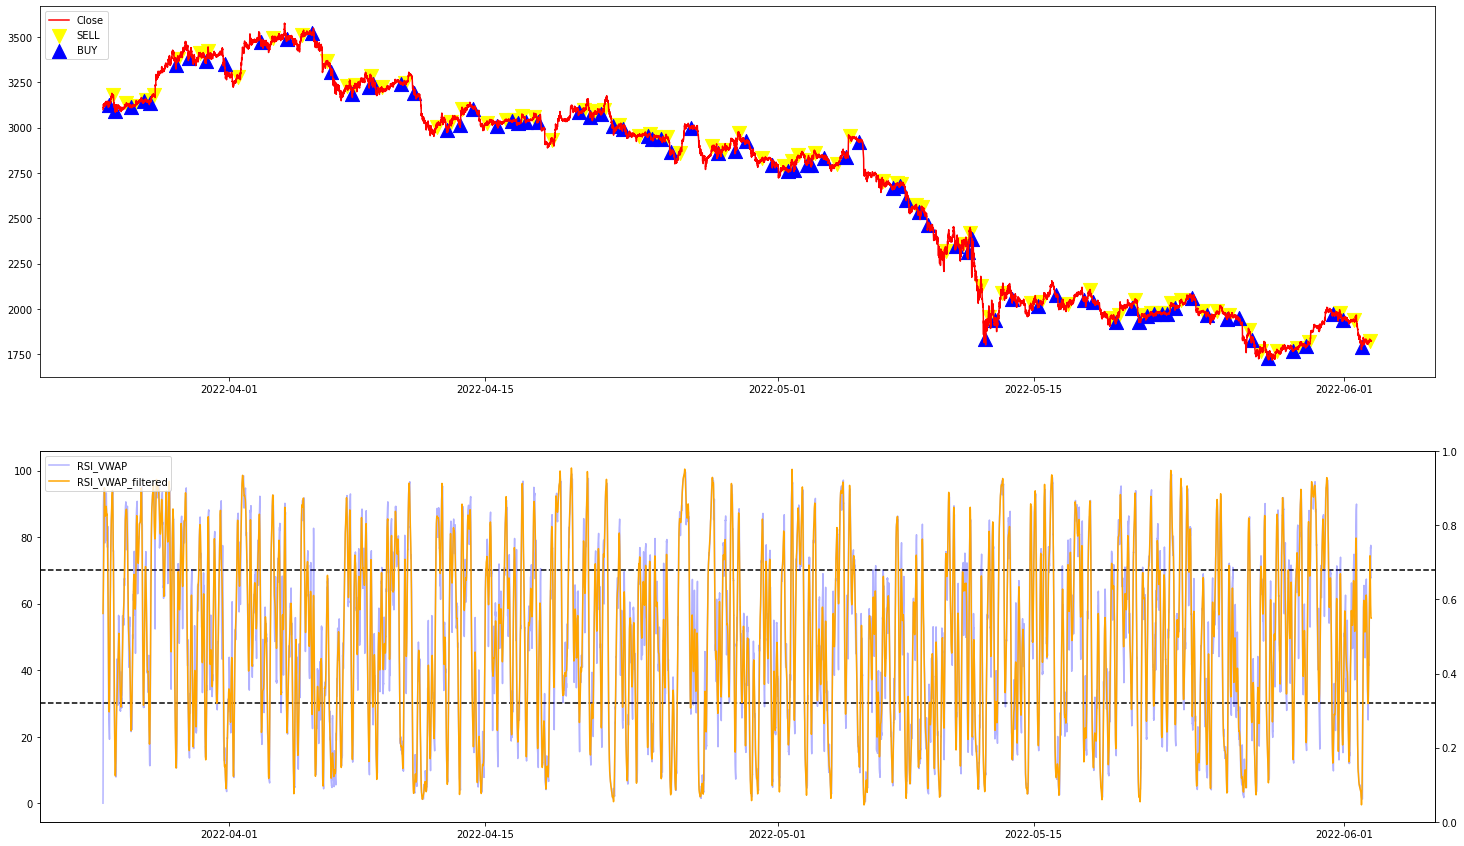

In [10]:
#df = getLastestData('SOL','5min',)
df = pd.read_csv('../backtest_tools/database/database/Binance/5m/ETH-USDT.csv',names=['Date','Open','High','Low','Close','Volume'])
df = df.iloc[1:]
df['Date'] = df['Date'].apply(lambda x: int(str(x)[:-3]))
df = df.astype(float)
df['Timestamp'] = df['Date'].astype(int)
df['Date'] = df['Date'].astype(int).apply(datetime.fromtimestamp)
df = df.set_index('Date')


df = df[-20000:]

df = computeIndicator(df)
df = computeBuySellSignal(df,'savgol')
df['BUY_SELL_true'] = 'HOLD'
trades = []
OPENED = False
for i in range(len(df)):
    if df['BUY_SELL'].iloc[i] == 'BUY' and OPENED == False:
        df['BUY_SELL_true'][i] = 'BUY'
        OPENED = True
    elif df['BUY_SELL'].iloc[i] == 'SELL' and OPENED == True:
        df['BUY_SELL_true'][i] = 'SELL'
        OPENED = False
trades = df[df['BUY_SELL_true']!='HOLD']
trades['Change']=trades.Close.pct_change()*100
trades_2 = trades[trades['BUY_SELL']=='SELL']
print(f"Gain : {round(trades_2.Change.sum())} %")
print(f"Winrate : {round(100*len(trades_2[trades_2['Change']>0].Change)/len(trades_2))} %")
print(f"Total trades : {len(trades_2)}")

fig, ax_left = plt.subplots(2, figsize=(25,15))

ax_left[0].plot(df.Close, color='red',label='Close')
ax_left[0].scatter(df[df['BUY_SELL_true']=='SELL'].index, df[df['BUY_SELL_true']=='SELL'].Close, color='yellow',label='SELL',marker='v',s=200)
ax_left[0].scatter(df[df['BUY_SELL_true']=='BUY'].index, df[df['BUY_SELL_true']=='BUY'].Close, color='blue',label='BUY',marker='^',s=200)
ax_left[1].axhline(y=30, color='black', linestyle='--')
ax_left[1].axhline(y=70, color='black', linestyle='--')
ax_left[0].legend(loc="upper left")
ax_left[1].plot(df['RSI_VWAP'], color='blue',label='RSI_VWAP',alpha=0.3)
ax_left[1].plot(df['RSI_VWAP_filtered'], color='orange',label='RSI_VWAP_filtered')
ax_r = ax_left[1].twinx()
ax_left[1].legend(loc="upper left")

df.tail()

# Adding MLR

In [ ]:
coefs_2 = []
intercepts_2 = []
from sklearn.linear_model import LinearRegression

window = 8
for i in range(window,len(df)):
    ys = df['Close'].values[i-window:i]
    xs = df.Timestamp.values[i-window:i].reshape(-1, 1)
    
    model = LinearRegression().fit(xs,ys)
    
    coefs_2.append(model.coef_[0])
    intercepts_2.append(model.intercept_)


df['B_MLR_coefs'] = np.nan
df['B_MLR_coefs'].iloc[window:] = coefs_2

df.dropna(inplace=True)
df['B_MLR_coefs_filtered'] = savgol_filter(df['B_MLR_coefs'].values, 20, 2,mode='nearest')

df['B_MLR_coefs_filtered_diff'] = df['B_MLR_coefs_filtered'].diff()
df.dropna(inplace=True)
df['B_MLR_coefs_filtered_MIN_MAX'] = np.nan
df['B_MLR_coefs_filtered_MIN_MAX'].iloc[1:] = ["HOLD" if np.sign(df['B_MLR_coefs_filtered_diff'][i-1])==np.sign(df['B_MLR_coefs_filtered_diff'][i]) else "BUY" if df['B_MLR_coefs_filtered_diff'][i-1]<0 and df['B_MLR_coefs_filtered_diff'][i]>0 else "SELL" for i in range(1,len(df))]
df.dropna(inplace=True)

In [ ]:
fig, ax_left = plt.subplots(3, figsize=(25,15))

ax_left[0].plot(df.Close, color='red',label='Close')
ax_left[1].axhline(y=15, color='black', linestyle='--')
ax_left[1].axhline(y=85, color='black', linestyle='--')
ax_left[0].legend(loc="upper left")
#ax_left[1].plot(df['RSI_VWAP'], color='blue',label='RSI_VWAP',alpha=0.3)
ax_left[1].plot(df['RSI_VWAP_filtered'], color='orange',label='RSI_VWAP_filtered')
ax_right = ax_left[1].twinx()
ax_right.plot(df['B_MLR_coefs_filtered'], color='blue',label='B_MLR_coefs_filtered')
ax_right.axhline(y=0, color='black', linestyle='--')
ax_right.legend(loc="upper right")
ax_left[1].legend(loc="upper left")
ax_left[2].plot(df['RSI_VWAP_filtered']+df['B_MLR_coefs_filtered']*800000, color='orange',label='RSI_VWAP_filtered x B_MLR_coefs_filtered')
ax_left[2].legend(loc="upper left")

# live Testing

In [ ]:
POSITION_OPENED = False
while True:
    try:       
        df = getLastestData('SOL','1min',)
        df = computeIndicator(df)
        df = computeBuySellSignal(df)
        current_last_rows = df.iloc[-6:]
        print(current_last_rows[['BUY_SELL','RSI_VWAP_filtered','RSI_VWAP_filtered_diff']])
        if POSITION_OPENED==False and 'BUY' in current_last_rows['BUY_SELL'].values:
            POSITION_OPENED=True
            print(f"BUY at {current_last_rows[current_last_rows['BUY_SELL']=='BUY'].Close.values[0]} USDT")
        elif POSITION_OPENED==True and 'SELL' in current_last_rows['BUY_SELL'].values:
            POSITION_OPENED=False
            print(f"SELL at {current_last_rows[current_last_rows['BUY_SELL']=='SELL'].Close.values[0]} USDT")
        else:
            print('HOLDING...')
        time.sleep(60)
    except:
        print('Error handled !')
